In [1]:
#@title Setup
import os
# ourddpm_dir = os.path.join("/content", "OurDDPM")

# from getpass import getpass
# print('Make your GitHub Personal access token and insert it below.')
# print('To get GitHub Personal Token,please refer to Section I in Supplementary Material.')
# github_token = getpass('GitHub Personal Token')
# ! git clone https://github.com/Gutianpei/Diffusion-Model-Playground.git $ourddpm_dir

# os.chdir(f'/content/OurDDPM')
os.makedirs("checkpoint", exist_ok=True)
os.makedirs("precomputed", exist_ok=True)
os.makedirs("pretrained", exist_ok=True)
os.makedirs("runs", exist_ok=True)

# ! pip install ftfy regex tqdm


# from utils.colab_utils import GoogleDrive_Dowonloader
# download_with_pydrive = True # param {type:"boolean"}
# dl = GoogleDrive_Dowonloader(download_with_pydrive)


from ourddpm import OurDDPM
from main import dict2namespace
import argparse
import yaml
from PIL import Image
import warnings
warnings.filterwarnings(action='ignore')

device = 'cuda'

%load_ext autoreload
%autoreload 2

/home/tonyx/Utils/anaconda3/envs/test/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# !wget -P pretrained/ https://image-editing-test-12345.s3-us-west-2.amazonaws.com/checkpoints/celeba_hq.ckpt

In [3]:
import torch
import pdb
import cv2
import glob
# from google.colab.patches import cv2_imshow
import pickle
import matplotlib.pyplot as plt

model_path = os.path.join("pretrained/celeba_hq.ckpt")

exp_dir = f"runs/raw_ddpm"
os.makedirs(exp_dir, exist_ok=True)

n_step =  999#@param {type: "integer"}
sampling = "ddpm" #@param ["ddpm", "ddim"]
fixed_xt = False #@param {type: "boolean"}
add_var = True #@param {type: "boolean"}
add_var_on = "0-999" #@param {type: "string"}
vis_gen =  True #@param {type: "boolean"}


args_dic = {
    'config': 'celeba.yml', 
    'n_step': int(n_step), 
    'sample_type': sampling, 
    'eta': 0.0,
    'bs_test': 1, 
    'model_path': model_path, 
    'hybrid_noise': 0, 
    'align_face': 0,
    'image_folder': exp_dir,
    'add_var': bool(add_var),
    'add_var_on': add_var_on
    }
args = dict2namespace(args_dic)

with open(os.path.join('configs', args.config), 'r') as f:
    config_dic = yaml.safe_load(f)
config = dict2namespace(config_dic)


if bool(add_var):
    var_scheduler = []
    periods = add_var_on.split(",")
    for period in periods:
        start = int(period.split("-")[0])
        end = int(period.split("-")[1])
        for n in range(start,end):
            var_scheduler.append(n)

Processing 0th sample...
pretrained/celeba_hq.ckpt is loaded.
Sampling type: DDPM with eta 0.0,  Steps: 999
Uniform skip type


Generative process: 100%|██████████| 999/999 [01:11<00:00, 13.89it/s]


Processing 1th sample...
pretrained/celeba_hq.ckpt is loaded.
Sampling type: DDPM with eta 0.0,  Steps: 999
Uniform skip type


Generative process: 100%|██████████| 999/999 [01:09<00:00, 14.30it/s]


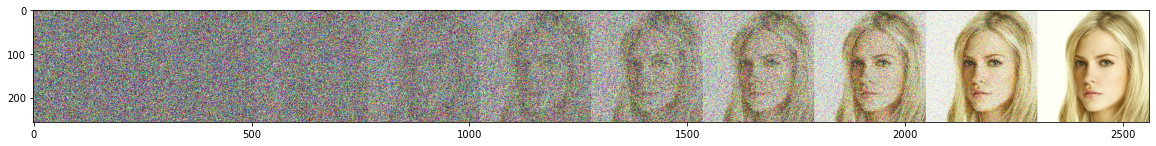

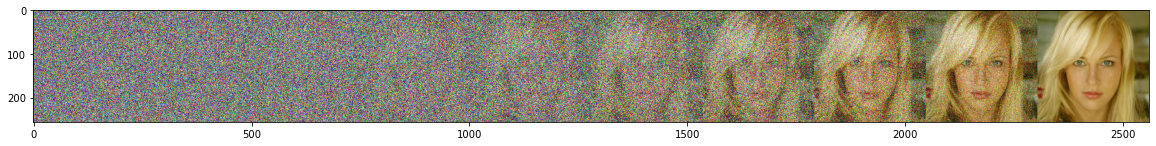

In [9]:
data_list = []

for i in range(2):
    print(f"Processing {i}th sample...")
    data_dic = {}
    device = torch.device("cuda")
    if bool(fixed_xt):
        torch.manual_seed(0)
        xt = torch.randn((1,3,256,256),device=device) 
    else:
        xt = torch.randn((1,3,256,256),device=device)
    config.device = device
    runner = OurDDPM(args, config, device=device)

    data_dic["xt"] = xt
    trajs, noise_traj = runner.generate_ddpm_and_noise_traj(xt,var_scheduler)
    data_dic["trajs"] = trajs
    data_dic["noise_traj"] = noise_traj


    # fuse output image
    if bool(vis_gen):
        img_dir = sorted(glob.glob(exp_dir+"/*.png"))[::-1]
        concat = []
        for img in img_dir:
            im = cv2.imread(img)
            concat.append(im)
        concat_img = cv2.hconcat(concat)
        display = concat_img
    else:
        img_dir = sorted(glob.glob(exp_dir+"/*.png"))[0]
        im = cv2.imread(img_dir)
        display = im

    display = cv2.cvtColor(display, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(20, 40))
    plt.imshow(display)
    data_list.append(data_dic)
    torch.cuda.empty_cache()
    
    
with open("data_1.obj","wb") as f:
    pickle.dump(data_list,f)


## Switch Trajectories

Processing 0th sample...
pretrained/celeba_hq.ckpt is loaded.
Sampling type: DDPM with eta 0.0,  Steps: 999
Uniform skip type


Generative process: 100%|██████████| 999/999 [01:10<00:00, 14.13it/s]


Processing 1th sample...
pretrained/celeba_hq.ckpt is loaded.
Sampling type: DDPM with eta 0.0,  Steps: 999
Uniform skip type


Generative process: 100%|██████████| 999/999 [01:11<00:00, 14.03it/s]


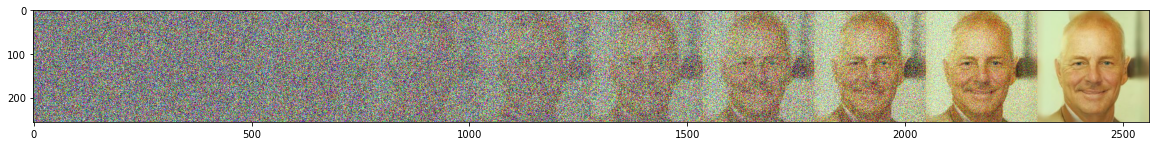

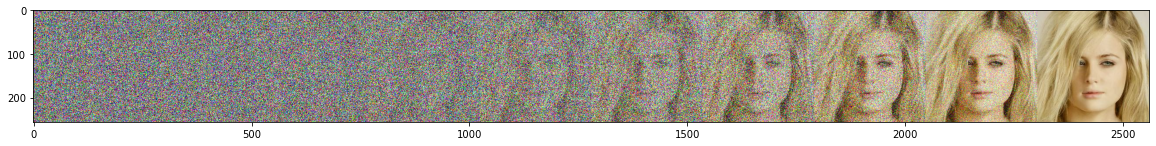

In [6]:
with open("data_1.obj","rb") as f:
    data_list = pickle.load(f)

res_list = []

for i in range(2):
    print(f"Processing {i}th sample...")
    temp = {}
    device = torch.device("cuda")
    config.device = device
    runner = OurDDPM(args, config, device=device)

    xt = data_list[i]["xt"]
    noise_traj = data_list[1-i]["noise_traj"][:500] + data_list[i]["noise_traj"][500:]

    trajs, noise_traj = runner.generate_ddpm_and_noise_traj(xt,var_scheduler, mode="use", noise_traj=noise_traj)
    temp["trajs"] = trajs


    # fuse output image
    if bool(vis_gen):
        img_dir = sorted(glob.glob(exp_dir+"/*.png"))[::-1]
        concat = []
        for img in img_dir:
            im = cv2.imread(img)
            concat.append(im)
        concat_img = cv2.hconcat(concat)
        display = concat_img
    else:
        img_dir = sorted(glob.glob(exp_dir+"/*.png"))[0]
        im = cv2.imread(img_dir)
        display = im

    display = cv2.cvtColor(display, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(20, 40))
    plt.imshow(display)
    res_list.append(temp)
    torch.cuda.empty_cache()
    
with open("data_1_swap_second_half.obj","wb") as f:
    pickle.dump(res_list,f)  
